<a href="https://colab.research.google.com/github/findmrkhan/cnn/blob/master/pokemon_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary modules

In [0]:
%config IPCompleter.greedy=True
%matplotlib inline

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras import backend
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
import os
import numpy as np
from os import listdir
from PIL import Image, ImageDraw, ImageFont
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Create a smaller VGG Net CNN model in Keras

In [0]:

class SmallerVGGNet1:

    @staticmethod
    def build_model(height, width, depth, classes):

        input_shape = (height, width, depth)
        channel_dim = 1
        model = Sequential()

        if backend.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            channel_dim = -1

        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D((3, 3), strides=3))
        model.add(Dropout(0.2))

        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))

        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D((2, 2), strides=2))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))

        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D((2, 2), strides=2))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation('softmax'))

        return model

Function to prepare data

In [0]:
#Data preparation
def makeDataLabels():
    print("In makeDataLabels")
    classes = listdir(dataset_path)

    data = []
    labels = []

    for aclass in classes:
        print("Class is ", aclass)
        ind = 0
        files = listdir(dataset_path + aclass)
        for file in files:
            ind = ind + 1
            labels.append(aclass)
            #image = cv2.imread(dataset_path + aclass + "/" + file)
            image = Image.open(dataset_path + aclass + "/" + file)
            #img = np.array(image)
            img = image.resize((96,96), Image.BILINEAR)
            arr = img_to_array(img)
            #print("Img  ", ind , "   ",  img)
            data.append(arr)

            #if ind >= 3:
            #    break

    data = np.array(data) / 255.0
    labels = np.array(labels)

    print("data ", len (data), "  label  ", len(labels))
    return data, labels

Function to use the prepared data, train the model and then save it

In [0]:
def useModel():
    print("In useModel")
    data, labels = makeDataLabels()
    print("Training data shape", data.shape)
    print("Training label shape", labels.shape)
    print("Data size : {} MB".format(data.nbytes / (1024 * 1024)))
    print("labels size : {} MB".format(labels.nbytes / (1024 * 1024)))

    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    
    print ("labels are : ", labels)
    print ("lb.classes_ : ", lb.classes_)

    (x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.1, random_state=45)

    model = SmallerVGGNet1.build_model(INPUT_HEIGHT, INPUT_WIDTH, INPUT_DEPTH, OUTPUT_CLASSES)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


    tensorboard_cb = TensorBoard(log_dir)
    
    aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
                             zoom_range=0.2, shear_range=0.2,
                       horizontal_flip=True, fill_mode="nearest")

    H = model.fit_generator(aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
                         validation_data=(x_test, y_test),
                        steps_per_epoch=len(x_train) // BATCH_SIZE,
                        epochs=EPOCHS, verbose=1
                            ,callbacks= [tensorboard_cb] 
                           )


    """
    H = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))
    """
    #print(model.weights)
    model.save(SAVED_MODEL)

    f = open(LABEL_BIN_FILE, "wb")
    f.write(pickle.dumps(lb))
    f.close()
    return H

Function to plot the losses and accuracy

In [0]:
def plotLosses(H=None):
    print("history ", H.history)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H.history['loss'], label ="loss")
    plt.plot(np.arange(0, EPOCHS), H.history['val_loss'],  label ="Val loss")
    plt.plot(np.arange(0, EPOCHS), H.history['acc'],  label ="accuracy")
    plt.plot(np.arange(0, EPOCHS), H.history['val_acc'],  label ="val accuracy")
    plt.title("Losses and acc")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Acc")
    plt.legend(loc="upper left")
    plt.savefig(LOSS_ACCURACY_PLOT_PATH)
    plt.show()

Initialise the parameters and call functions to train the model and plot losses

In useModel
In makeDataLabels
Class is  bulbasaur
Class is  charmander
Class is  squirtle
Class is  mewtwo
Class is  pikachu
data  956   label   956
Training data shape (956, 96, 96, 3)
Training label shape (956,)
Data size : 100.828125 MB
labels size : 0.036468505859375 MB
labels are :  [[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]
lb.classes_ :  ['bulbasaur' 'charmander' 'mewtwo' 'pikachu' 'squirtle']
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_57 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 96, 96, 32)        384       
_________________________________________________________________
max_p

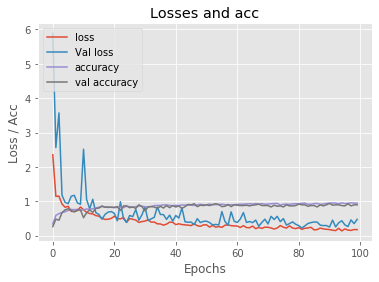

In [0]:
BATCH_SIZE = 100
EPOCHS = 100
INPUT_HEIGHT = 96
INPUT_WIDTH = 96
INPUT_DEPTH = 3
OUTPUT_CLASSES = 5
SAVED_MODEL = "/content/drive/My Drive/pokemon_dataset/pokedex.model"
LABEL_BIN_FILE = "/content/drive/My Drive/pokemon_dataset/labelBinFile.pickle"
dataset_path = "/content/drive/My Drive/pokemon_dataset/training/"
log_dir = "/content/drive/My Drive/pokemon_dataset/"
LOSS_ACCURACY_PLOT_PATH = "/content/drive/My Drive/pokemon_dataset/lossaccplot.jpg"

hst = useModel()
plotLosses(hst)


Load the saved model 


In [0]:
loaded_model = load_model( SAVED_MODEL )

lb = pickle.load(open(LABEL_BIN_FILE, "rb"))


Plot on a grid all the images placed in a given folder 


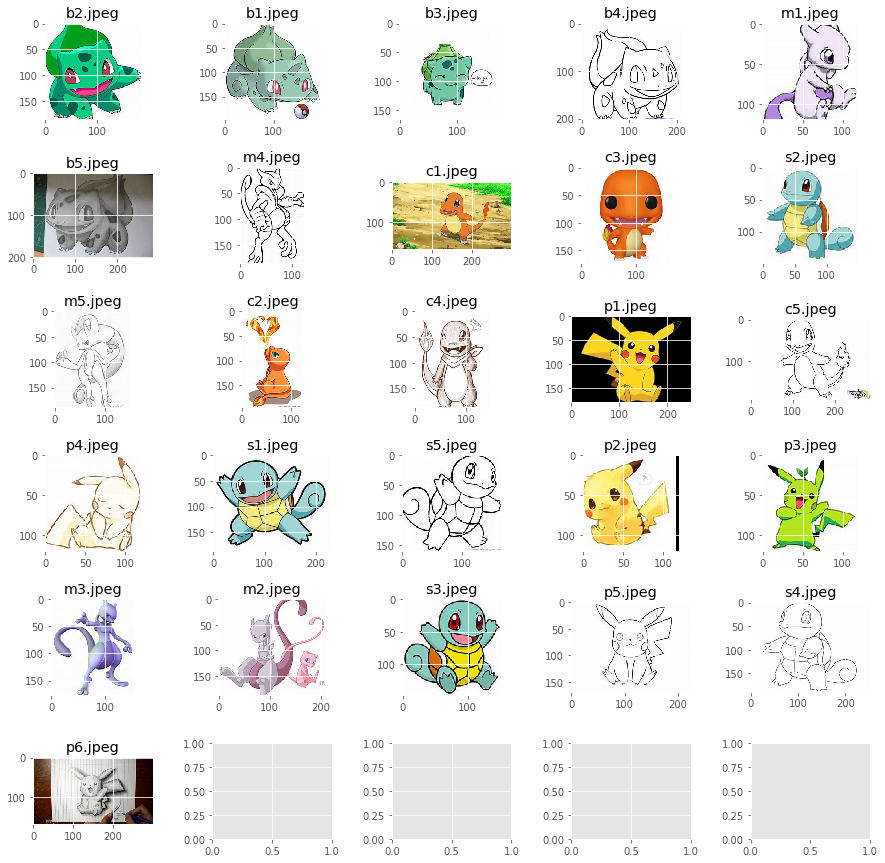

In [0]:
def plotImageGrid( path="", columns=4, figsize=(15, 15)):
    #fig = plt.figure()
    if len(path) == 0 :
        return
    if columns <= 0 :
        return

    files = os.listdir(path)
    if len(files) <= 0:
        return
        
    imgs = []

    for f in files:
        img = Image.open(path + f)
        imgs.append (img)


    rows = (len(imgs) // columns) + 1

    f, axarr = plt.subplots(rows, columns, figsize=figsize)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for r in range(0, rows):
        for c in range(0, columns):
            if len(imgs) - 1 >= (r * columns) + c :
                axarr[r, c].imshow(imgs[ (r * columns) + c])
                axarr[r, c].set_title (files[(r * columns) + c])

    plt.grid(False)
    plt.show()
    

IMAGE_PATH = "/content/drive/My Drive/pokemon_dataset/testing/" 
plotImageGrid(IMAGE_PATH, 5)


Take a sample test image and predict the outcome

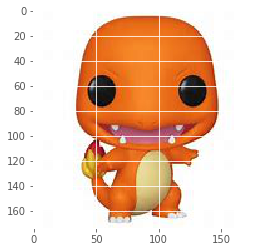

prediction =  [0. 1. 0. 0. 0.]
output class is :  charmander


In [0]:
sampleimg_path = "/content/drive/My Drive/pokemon_dataset/testing/c3.jpeg"
sampleimg = Image.open(sampleimg_path)
plt.imshow(sampleimg)
plt.show()

sampleimg = sampleimg.resize((96,96) , Image.BILINEAR)
sampleimg = img_to_array(sampleimg)
sampleimg = np.expand_dims(sampleimg, axis=0)

predict = loaded_model.predict(sampleimg)[0]
print ("prediction = ", predict)
idx = np.argmax(predict)

classname = lb.classes_[idx]
print( "output class is : " , classname)
#fig = plt.figure()
#sp = fig.add_subplot(421)

